# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
from datetime import datetime

# Load data

In [2]:
# Load data
fraud_df = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../data/raw/ipAddress_to_Country.csv")


# 2. Initial Inspection

In [3]:
fraud_df.head()
fraud_df.info()
fraud_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


# 3. Missing Values

In [4]:
fraud_df.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

# 4. Clean Data

In [5]:
df = fraud_df.copy()
df.drop_duplicates(inplace=True)
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['purchase_value'] = pd.to_numeric(df['purchase_value'], errors='coerce')
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df.dropna(inplace=True)

# 5. EDA - Univariate

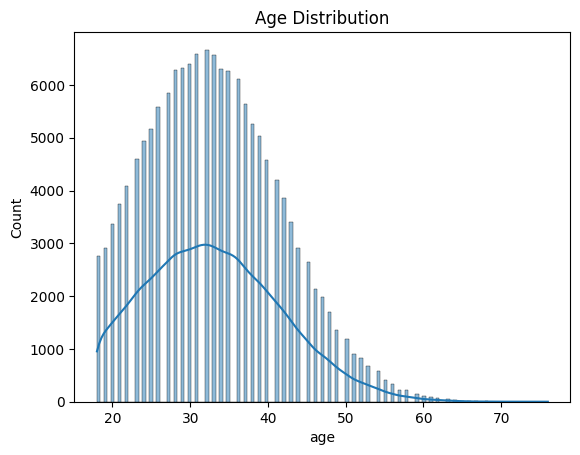

In [6]:
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.show()


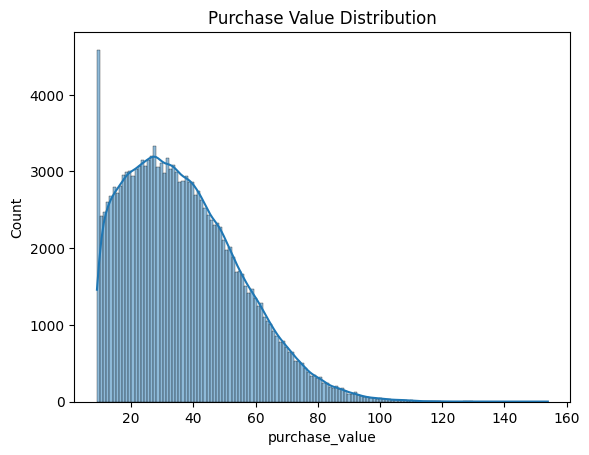

In [7]:
sns.histplot(df['purchase_value'], kde=True)
plt.title('Purchase Value Distribution')
plt.show()


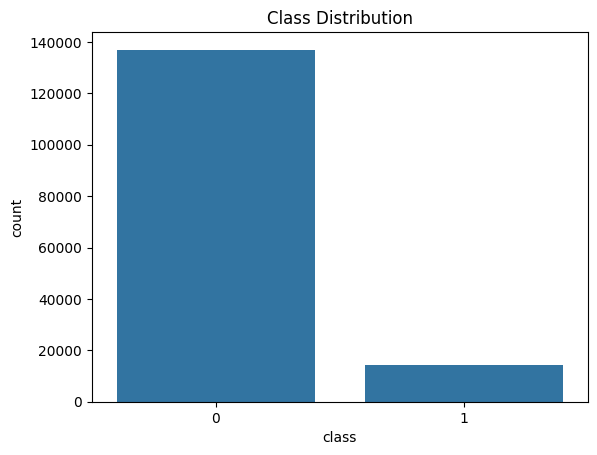

In [8]:
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

# 6. EDA - Bivariate

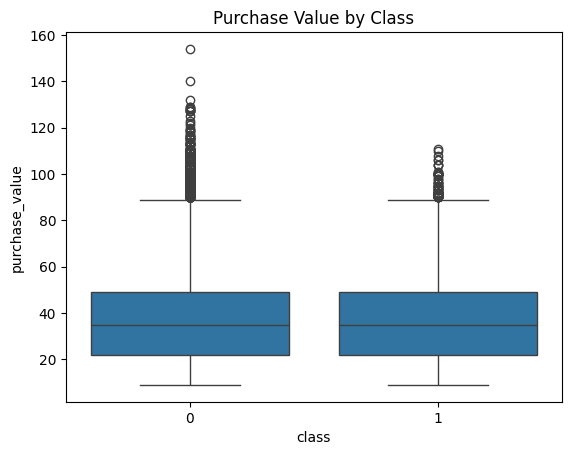

In [9]:
sns.boxplot(x='class', y='purchase_value', data=df)
plt.title('Purchase Value by Class')
plt.show()

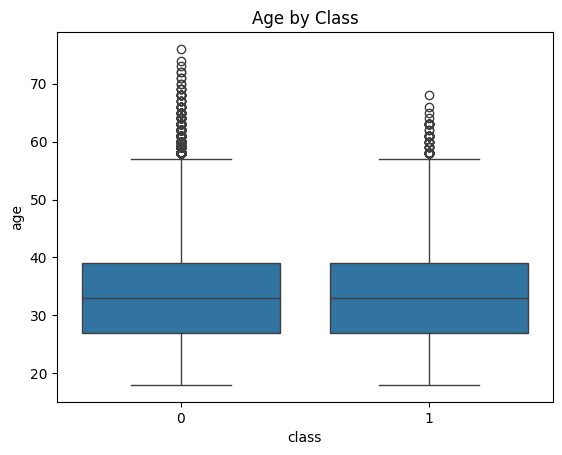

In [10]:
sns.boxplot(x='class', y='age', data=df)
plt.title('Age by Class')
plt.show()

# 7. Feature Engineering

In [11]:

df['hour_of_day'] = df['purchase_time'].dt.hour
df['day_of_week'] = df['purchase_time'].dt.dayofweek
df['time_since_signup'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600
df['transaction_count'] = df.groupby('user_id')['user_id'].transform('count')


# 8. Correlation

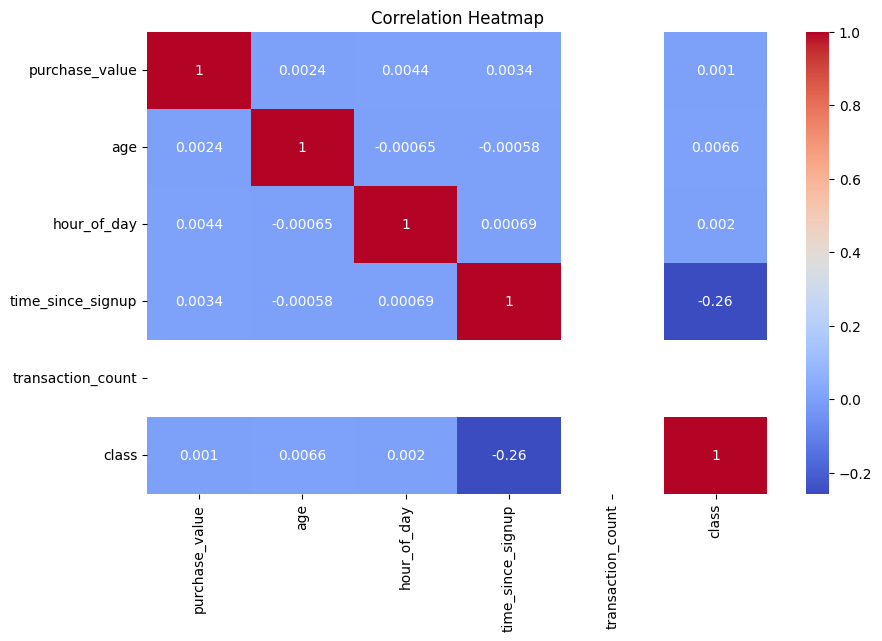

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['purchase_value', 'age', 'hour_of_day', 'time_since_signup', 'transaction_count', 'class']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 9. IP Mapping

In [13]:

def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except:
        return None

In [14]:
df['ip_int'] = df['ip_address'].apply(ip_to_int)
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].apply(ip_to_int)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].apply(ip_to_int)


In [15]:
def map_country(ip):
    match = ip_df[(ip_df['lower_bound_ip_address'] <= ip) & (ip_df['upper_bound_ip_address'] >= ip)]
    return match['country'].values[0] if not match.empty else 'Unknown'

df['country'] = df['ip_int'].apply(map_country)


# Country distribution

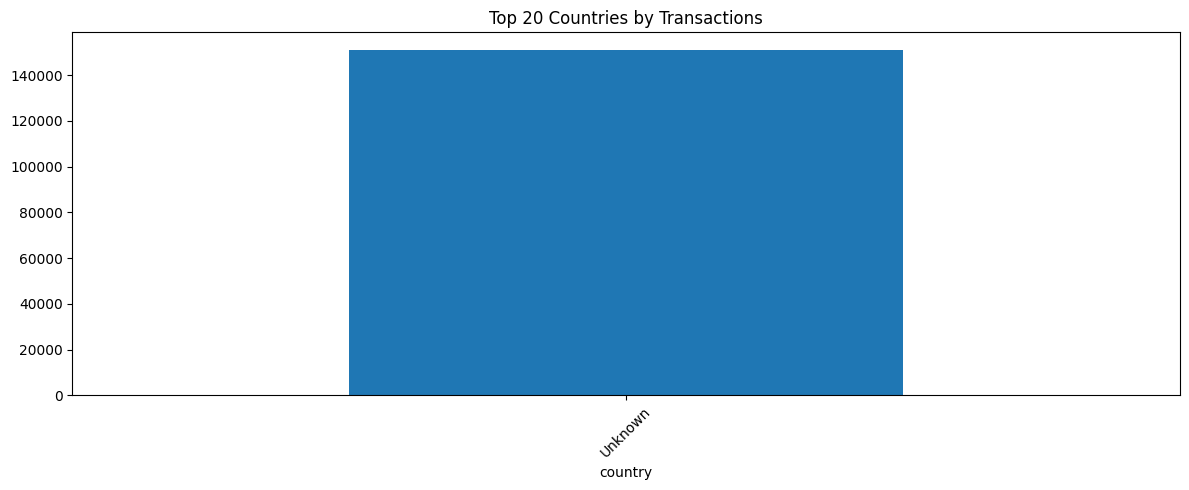

In [16]:
plt.figure(figsize=(12, 5))
df['country'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Countries by Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save processed data

In [18]:
df.to_csv("../data/processed/fraud_features.csv", index=False)
print("Saved: fraud_features.csv")


Saved: fraud_features.csv
